In [ ]:
pip install transformers datasets kagglehub scikit-learn

###IMDB Data

In [ ]:
from datasets import load_dataset

dataset = load_dataset("imdb")
train_texts = dataset["train"]["text"]
train_labels = dataset["train"]["label"]
test_texts = dataset["test"]["text"]
test_labels = dataset["test"]["label"]

In [ ]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased", output_hidden_states=True)

In [ ]:
def tokenize(texts, tokenizer, max_len=128):
    return tokenizer(texts, padding=True, truncation=True, max_length=max_len, return_tensors="pt")

In [ ]:
import torch

def get_embedding_strategy(hidden_states, strategy="last"):
    if strategy == "first":
        return hidden_states[1][:, 0]
    elif strategy == "last":
        return hidden_states[-1][:, 0]
    elif strategy == "second_to_last":
        return hidden_states[-2][:, 0]
    elif strategy == "sum_all_12":
        return torch.sum(torch.stack(hidden_states[1:]), dim=0)[:, 0]
    elif strategy == "sum_last_4":
        return torch.sum(torch.stack(hidden_states[-4:]), dim=0)[:, 0]
    elif strategy == "concat_last_4":
        return torch.cat([hidden_states[-i][:, 0] for i in range(1, 5)], dim=-1)
    else:
        raise ValueError(f"Unknown strategy")

####Training and Evaluation

In [ ]:
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score

class SentimentClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc = nn.Linear(input_dim, 2)

    def forward(self, x):
        return self.fc(x)

In [ ]:
def train_and_evaluate(bert, strategy, train_texts, train_labels, test_texts, test_labels):
    bert.eval()
    inputs = tokenize(train_texts[:500], tokenizer)
    labels = torch.tensor(train_labels[:500])

    with torch.no_grad():
        outputs = bert(**inputs)
        hidden_states = outputs.hidden_states
        features = get_embedding_strategy(hidden_states, strategy=strategy)

    classifier = SentimentClassifier(features.shape[1])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(classifier.parameters(), lr=1e-4)

    for epoch in range(5):
        optimizer.zero_grad()
        outputs = classifier(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    inputs_test = tokenize(test_texts[:500], tokenizer)
    labels_test = torch.tensor(test_labels[:500])

    with torch.no_grad():
        outputs = bert(**inputs)
        hidden_states = outputs.hidden_states
        test_features = get_embedding_strategy(hidden_states, strategy=strategy)
        predictions = classifier(test_features)
        predicted_labels = torch.argmax(predictions, dim=1)

    acc = accuracy_score(labels_test, predicted_labels)
    return acc

In [ ]:
strategies = ["first",
              "last",
              "second_to_last",
              "sum_all_12",
              "sum_last_4",
              "concat_last_4"]

results = {}

for s in strategies:
    print(f"\n Training & Evaluating with strategy: {s}")
    acc = train_and_evaluate(bert, s, train_texts, train_labels, test_texts, test_labels)
    results[s] = acc
    print(f"Accuracy with {s}: {acc:.4f}")


 Training & Evaluating with strategy: first
Accuracy with first: 0.9940

 Training & Evaluating with strategy: last
Accuracy with last: 0.7920

 Training & Evaluating with strategy: second_to_last
Accuracy with second_to_last: 0.8060

 Training & Evaluating with strategy: sum_all_12
Accuracy with sum_all_12: 0.9960

 Training & Evaluating with strategy: sum_last_4
Accuracy with sum_last_4: 0.3760

 Training & Evaluating with strategy: concat_last_4
Accuracy with concat_last_4: 1.0000


####Comparison

         Strategy  Accuracy
0           first     0.994
1            last     0.792
2  second_to_last     0.806
3      sum_all_12     0.996
4      sum_last_4     0.376
5   concat_last_4     1.000


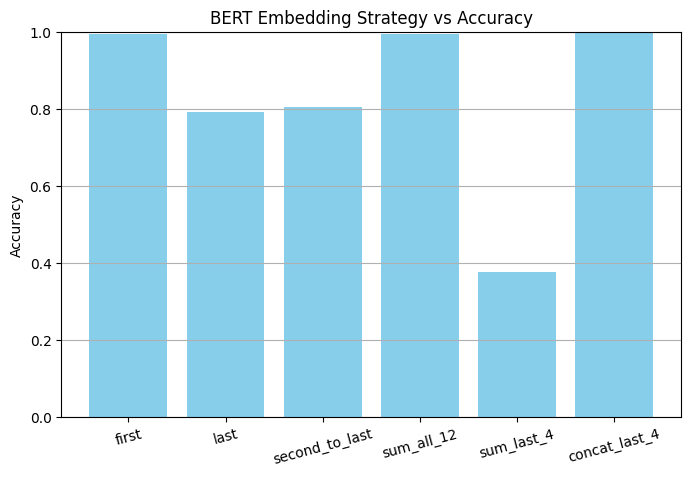

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(list(results.items()), columns=["Strategy", "Accuracy"])
print(df)

plt.figure(figsize=(8,5))
plt.bar(df["Strategy"], df["Accuracy"], color="skyblue")
plt.title("BERT Embedding Strategy vs Accuracy")
plt.ylabel("Accuracy")
plt.ylim(0.0, 1.0)
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.show()

###NLI Data

In [ ]:
from datasets import load_dataset

dataset = load_dataset("snli")
train_data = dataset["train"].filter(lambda x: x["label"] != -1)
test_data = dataset["validation"].filter(lambda x: x["label"] != -1)

Filter:   0%|          | 0/550152 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
# Extract premises, hypotheses, and labels
premises = train_data["premise"]
hypotheses = train_data["hypothesis"]
labels = train_data["label"]

# Similarly for test data
test_premises = test_data["premise"]
test_hypotheses = test_data["hypothesis"]
test_labels = test_data["label"]

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertModel
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased", output_hidden_states=True)
bert.eval()  # Freeze BERT

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
def tokenize(premises, hypotheses, max_len=128):
    return tokenizer(
        premises,
        hypotheses,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
        max_length=max_len,
    )

In [ ]:
def get_embedding_strategy(hidden_states, strategy="last"):
    if strategy == "first":
        return hidden_states[1][:, 0]
    elif strategy == "last":
        return hidden_states[-1][:, 0]
    elif strategy == "second_to_last":
        return hidden_states[-2][:, 0]
    elif strategy == "sum_all_12":
        return torch.sum(torch.stack(hidden_states[1:]), dim=0)[:, 0]
    elif strategy == "sum_last_4":
        return torch.sum(torch.stack(hidden_states[-4:]), dim=0)[:, 0]
    elif strategy == "concat_last_4":
        return torch.cat([hidden_states[-i][:, 0] for i in range(1, 5)], dim=-1)
    else:
        raise ValueError(f"Unknown strategy: {strategy}")

####Training and Evaluation

In [ ]:
class NLIClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc = nn.Linear(input_dim, 3)

    def forward(self, x):
        return self.fc(x)


def train_and_evaluate(bert, strategy, premises, hypotheses, labels, test_premises, test_hypotheses, test_labels, device):
    # Use a small subset for speed
    premises, hypotheses, labels = premises[:500], hypotheses[:500], labels[:500]
    test_premises, test_hypotheses, test_labels = test_premises[:500], test_hypotheses[:500], test_labels[:500]

    # Tokenize train
    inputs = tokenize(premises, hypotheses)  # Assume this returns a dict with 'input_ids', 'attention_mask', etc.
    inputs = {key: value.to(device) for key, value in inputs.items()}

    with torch.no_grad():
        outputs = bert(**inputs, output_hidden_states=True)
        features = get_embedding_strategy(outputs.hidden_states, strategy)  # Ensure this function handles your strategies

    # Convert labels to tensor
    labels = torch.tensor(labels).to(device)

    # Initialize classifier
    classifier = NLIClassifier(features.shape[1]).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(classifier.parameters(), lr=1e-4)

    # Training loop
    for epoch in range(5):
        classifier.train()
        optimizer.zero_grad()
        preds = classifier(features)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()

    # Tokenize test
    inputs_test = tokenize(test_premises, test_hypotheses)
    inputs_test = {key: value.to(device) for key, value in inputs_test.items()}

    with torch.no_grad():
        outputs_test = bert(**inputs_test, output_hidden_states=True)
        test_features = get_embedding_strategy(outputs_test.hidden_states, strategy)
        preds_test = classifier(test_features)
        pred_labels = torch.argmax(preds_test, dim=1)

    acc = accuracy_score(test_labels[:500], pred_labels.cpu().numpy())  # Make sure to move to CPU before calculating accuracy
    return acc

In [ ]:
strategies = ["first",
            "last",
            "second_to_last",
            "sum_all_12",
            "sum_last_4",
            "concat_last_4"]

results = {}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert = bert.to(device)

for s in strategies:
    print(f"\n Training & Evaluating with strategy: {s}")
    acc = train_and_evaluate(bert, s, premises, hypotheses, labels, test_premises, test_hypotheses, test_labels, device)
    results[s] = acc
    print(f"Accuracy with {s}: {acc:.4f}")


 Training & Evaluating with strategy: first
Accuracy with first: 0.3200

 Training & Evaluating with strategy: last
Accuracy with last: 0.3200

 Training & Evaluating with strategy: second_to_last
Accuracy with second_to_last: 0.3480

 Training & Evaluating with strategy: sum_all_12
Accuracy with sum_all_12: 0.2640

 Training & Evaluating with strategy: sum_last_4
Accuracy with sum_last_4: 0.3240

 Training & Evaluating with strategy: concat_last_4
Accuracy with concat_last_4: 0.3880


####Comparison

         Strategy  Accuracy
0           first     0.320
1            last     0.320
2  second_to_last     0.348
3      sum_all_12     0.264
4      sum_last_4     0.324
5   concat_last_4     0.388


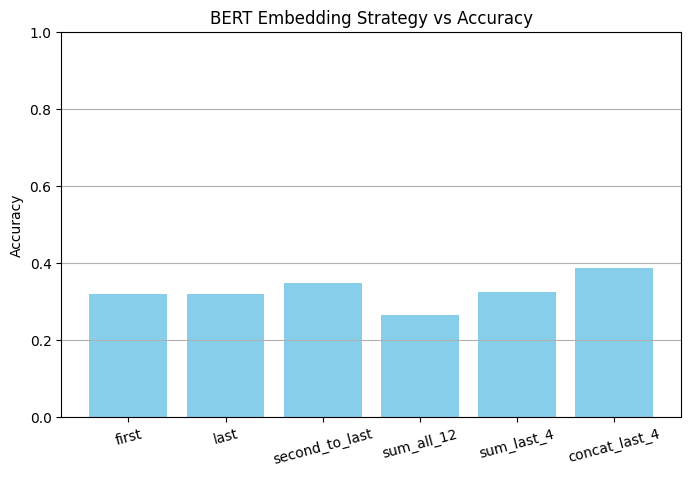

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(list(results.items()), columns=["Strategy", "Accuracy"])
print(df)

plt.figure(figsize=(8,5))
plt.bar(df["Strategy"], df["Accuracy"], color="skyblue")
plt.title("BERT Embedding Strategy vs Accuracy")
plt.ylabel("Accuracy")
plt.ylim(0.0, 1.0)
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.show()